<a href="https://colab.research.google.com/github/BSniegowski/ML-uni_course/blob/main/lab/mdd_eeg_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://figshare.com/ndownloader/articles/4244171/versions/2
!unzip 2
!pip install mne

In [2]:
#@title load files
import os
import mne

mne.set_log_level('ERROR')


raws = []
for file in os.scandir('.'):
  _, ext = os.path.splitext(file.path)
  if ext == ".edf":
    raws.append(mne.io.read_raw_edf(file.path))

In [3]:
#@title Dataset class
import torch
from torch.utils.data import Dataset

# at first let's ignore timestamps, that is treat the measurements as sequences
# instead of functions of time
class CustomDataset(Dataset):
  def __init__(self, raws, transform=None):
    self.data = []
    self.labels = []
    for raw in raws:
      segment_length = 60 # in seconds
      label = 1 if "MDD" in raw.filenames[0] else 0
      print(f'label {label} for filename {raw.filenames[0]}')
      data = torch.squeeze(torch.as_tensor(raw.load_data()[:20,:][0]))
      length_seconds = data.size()[1]/256
      i=0
      while (i+1)*segment_length < length_seconds:
        self.data.append(data[:,i*segment_length*256:(i+1)*segment_length*256])
        self.labels.append(label)
        i += 1

    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self,idx):
    X, y = self.data[idx], self.labels[idx]
    if self.transform is not None:
      X = self.transform(X)
    X = torch.as_tensor(X[None, ...])
    return X, y

def scale(X):
  X -= torch.mean(X, axis=1, keepdims=True)
  return X / torch.std(X, axis=1, keepdims=True)

In [ ]:
#@title DataLoaders
from torch.utils.data import random_split, DataLoader


dataset = CustomDataset(raws, transform=scale)

train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_batch_size = 4
test_batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, drop_last=True)

In [5]:
#@title show results
def show_results(logs):
  f, ax = plt.subplots(1, 2, figsize=(16, 5))
  ax[0].plot(logs['train_accuracy'], color='b', linestyle='--', label='train')
  ax[0].plot(logs['test_accuracy'], color='g', label='test')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(logs['train_loss'], color='b', linestyle='--', label='train')
  ax[1].plot(logs['test_loss'], color='g', label='test')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

In [20]:
#@title MyModel
from torch import nn
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=5, stride=3, padding=2),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=32),
        nn.MaxPool2d(kernel_size=3, stride=1),
        nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=32),
        nn.MaxPool2d(kernel_size=3, stride=1),
    )
    self.adaptivepool = nn.AdaptiveAvgPool2d((20, 64))
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(32*20*64, 1),
        nn.Sigmoid()
    )
    
  def forward(self, x):
    x = self.conv(x)
    x = self.adaptivepool(x)
    x = torch.flatten(x, start_dim=1)
    x = self.classifier(x)
    return x

In [28]:
#@title train loop
from torch import nn
import matplotlib.pyplot as plt


def train(model, optimizer, loss_fn, learning_rate, n_epochs, logs):
  model.train()

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  correct, numel = 0, 0
  train_fp, train_fn = 0, 0
  test_fp, test_fn = 0, 0

  for i in range(n_epochs):
    model.train()

    for x, y in train_loader:
      x = x.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      output = model(x)
      output = torch.squeeze(output)
      y_pred = output > 0.5
      correct += torch.sum(y_pred == y).item()
      numel += train_loader.batch_size
      for i in range(y_pred.size()[0]):
        if y_pred[i] == 1 and y[i] == 0: train_fp += 1
        elif y_pred[i] == 0 and y[i] == 1: train_fn += 1
      y = y.double()
      loss = loss_fn(output, y)
      loss.backward()
      optimizer.step()
    print(f'False positive: {train_fp}, false negative: {train_fn}')

    logs['train_loss'].append(loss.item())
    logs['train_accuracy'].append(correct / numel)
    correct, numel = 0, 0

    model.eval()
    with torch.no_grad():
      for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        output = model(x_test)
        output = torch.squeeze(output)
        # print('test', output)
        y_pred = output > 0.5
        for i in range(y_pred.size()[0]):
          if y_pred[i] == 1 and y_test[i] == 0: test_fp += 1
          elif y_pred[i] == 0 and y_test[i] == 1: test_fn += 1
        correct += torch.sum(y_pred == y_test).item()
        numel += test_loader.batch_size
      print(f"Test. false positive: {test_fp}, false negative: {test_fn}")
      y_test = y_test.double()
      loss = loss_fn(output, y_test)

    logs['test_loss'].append(loss.item())
    logs['test_accuracy'].append(correct / numel)
    correct, numel = 0, 0
    show_results(logs)
    plt.pause(1e-10)

Device:  cuda:0
False positive: 136, false negative: 141
Test. false positive: 41, false negative: 6


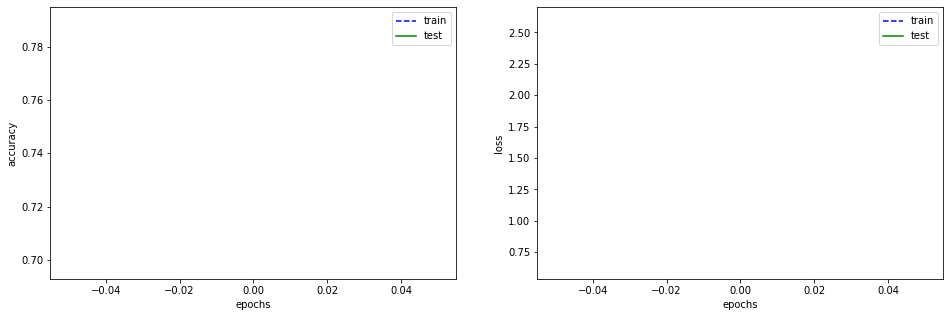

False positive: 241, false negative: 242
Test. false positive: 76, false negative: 16


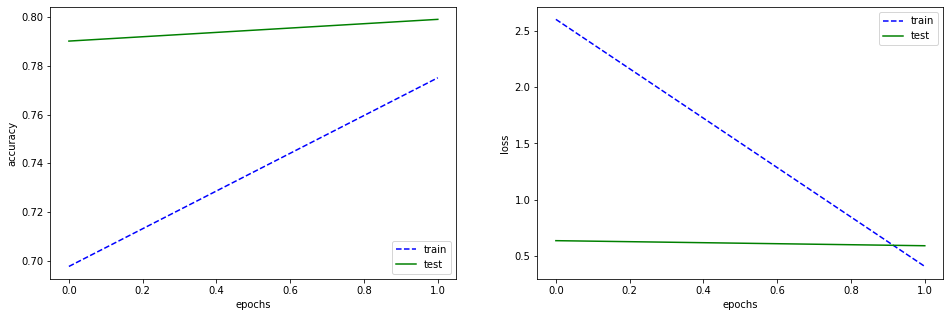

False positive: 322, false negative: 306
Test. false positive: 110, false negative: 21


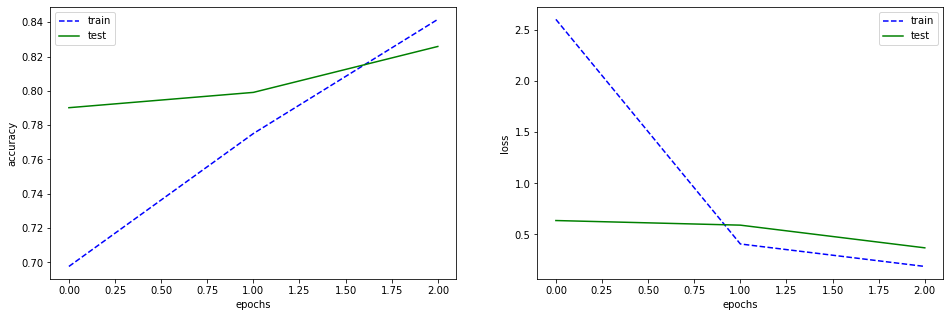

False positive: 376, false negative: 347
Test. false positive: 143, false negative: 25


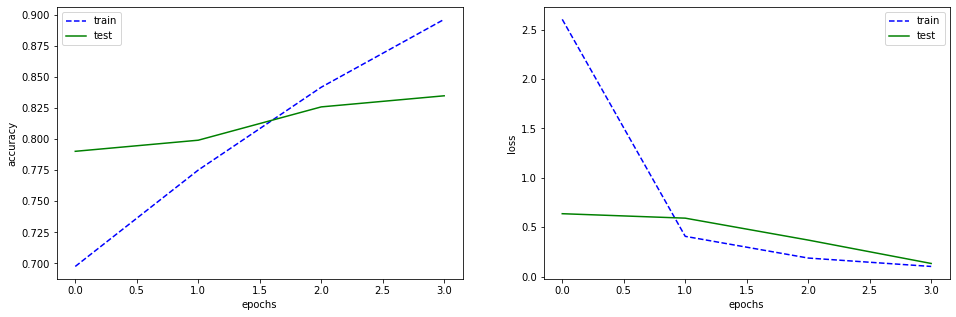

False positive: 434, false negative: 396
Test. false positive: 179, false negative: 34


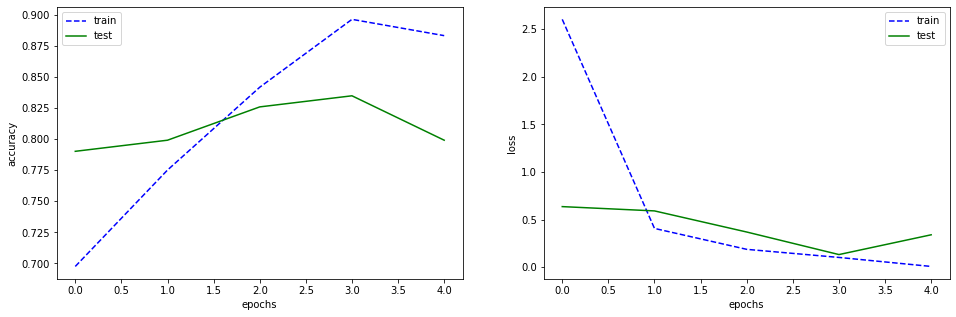

False positive: 477, false negative: 427
Test. false positive: 201, false negative: 40


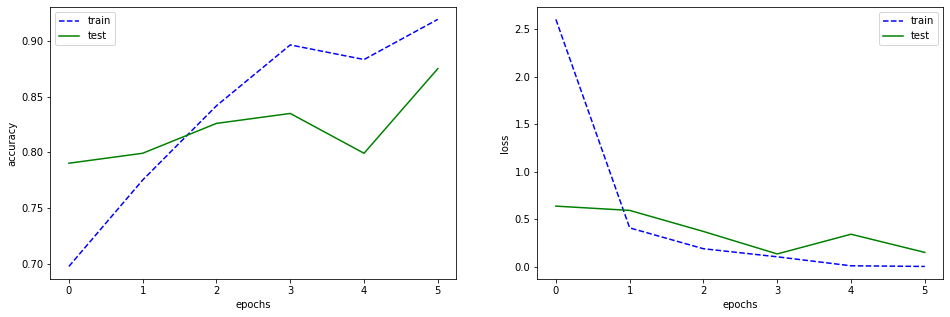

False positive: 517, false negative: 473
Test. false positive: 216, false negative: 48


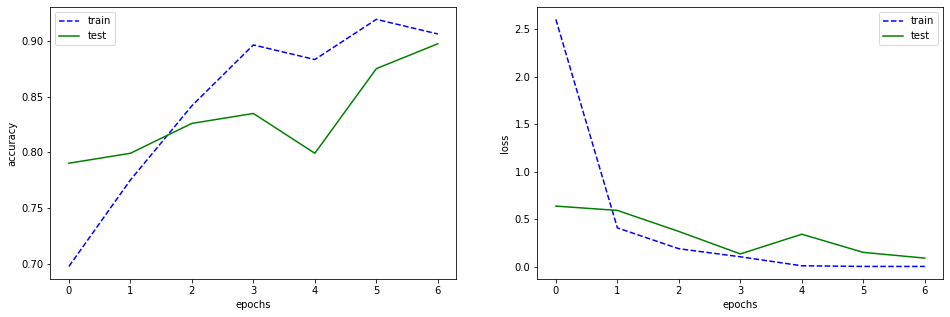

False positive: 547, false negative: 497
Test. false positive: 237, false negative: 58


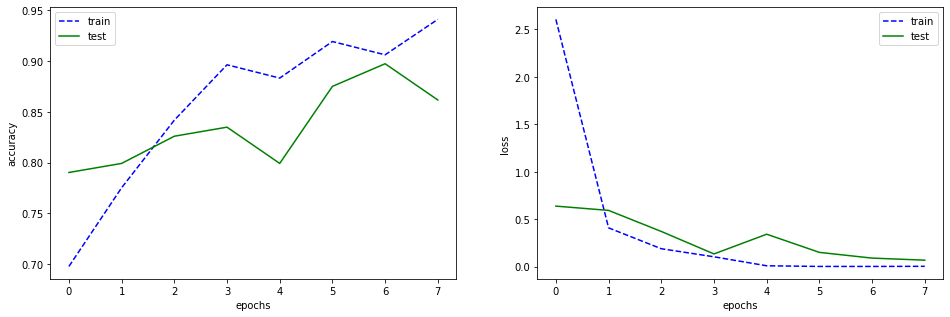

False positive: 574, false negative: 517
Test. false positive: 255, false negative: 66


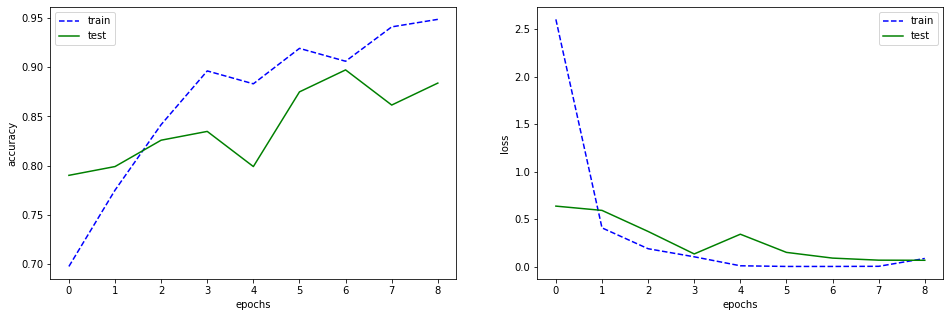

False positive: 593, false negative: 535
Test. false positive: 262, false negative: 78


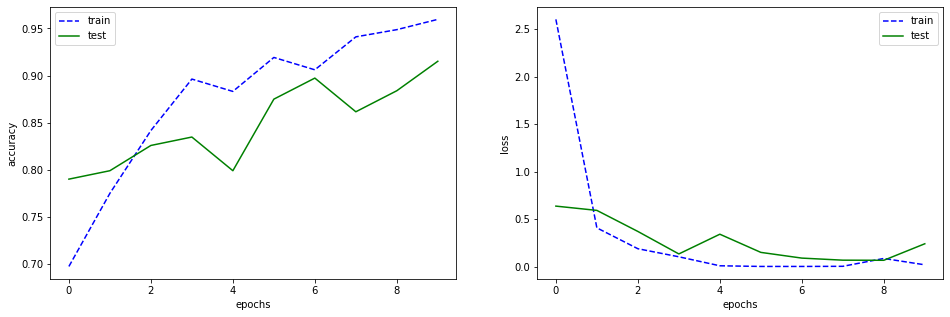

False positive: 612, false negative: 552
Test. false positive: 266, false negative: 93


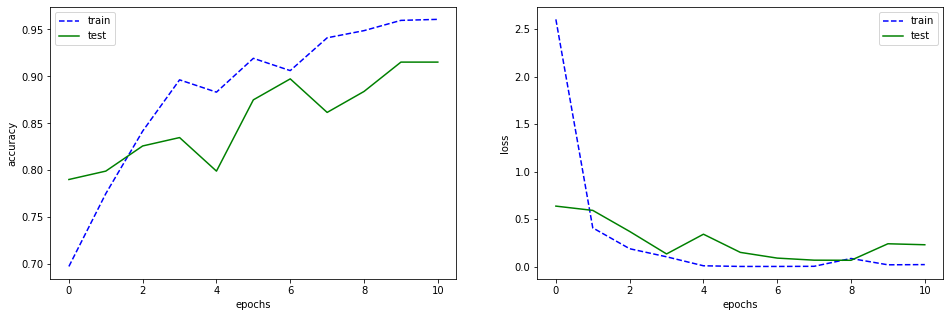

False positive: 636, false negative: 573
Test. false positive: 283, false negative: 97


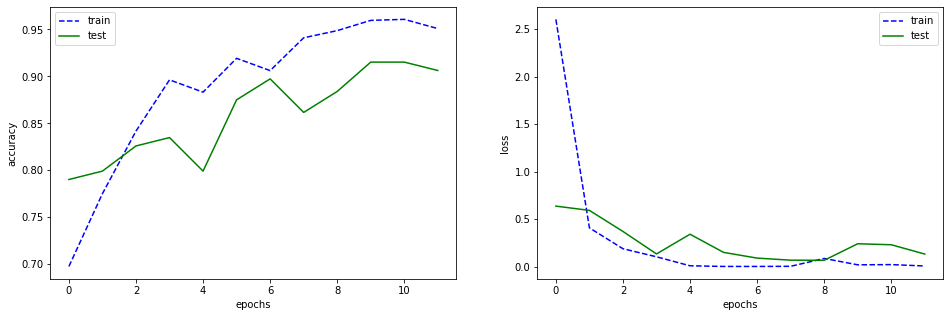

False positive: 654, false negative: 590
Test. false positive: 297, false negative: 107


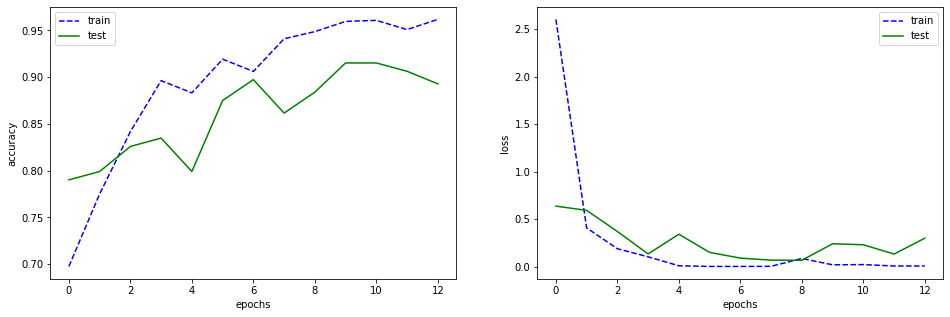

False positive: 668, false negative: 601
Test. false positive: 304, false negative: 114


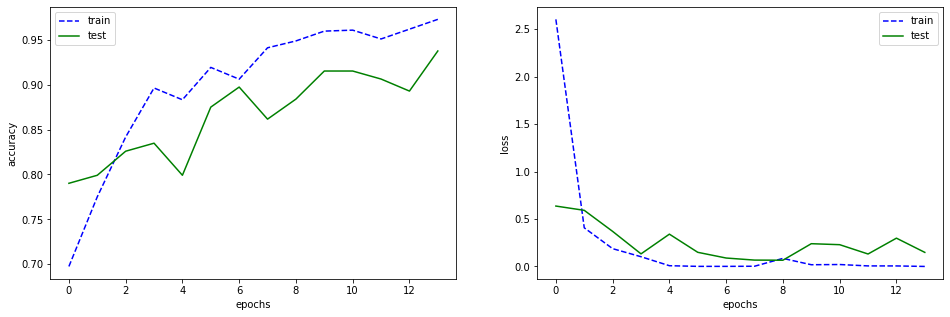

False positive: 675, false negative: 610
Test. false positive: 314, false negative: 120


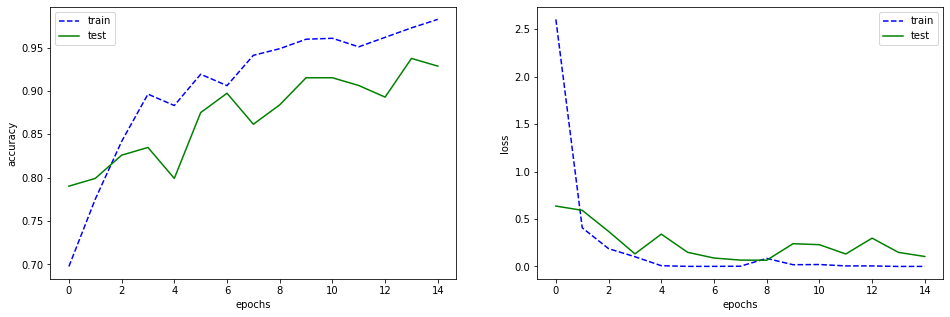

False positive: 683, false negative: 619
Test. false positive: 324, false negative: 131


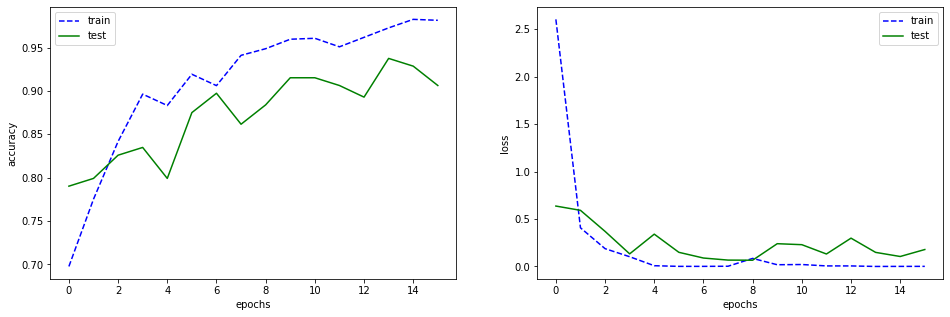

False positive: 690, false negative: 624
Test. false positive: 327, false negative: 155


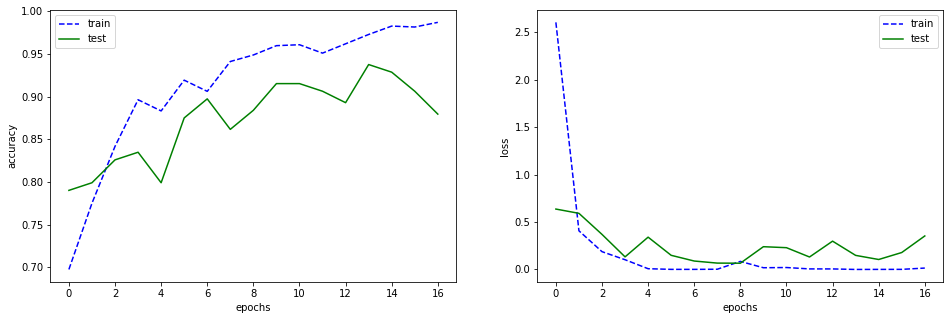

False positive: 697, false negative: 630
Test. false positive: 409, false negative: 158


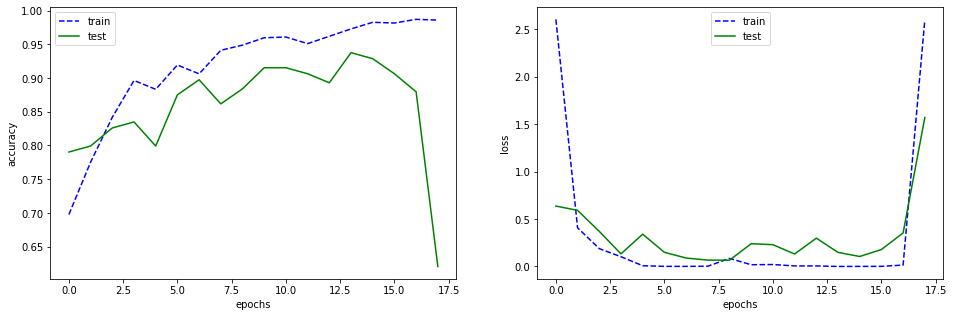

False positive: 710, false negative: 638
Test. false positive: 412, false negative: 175


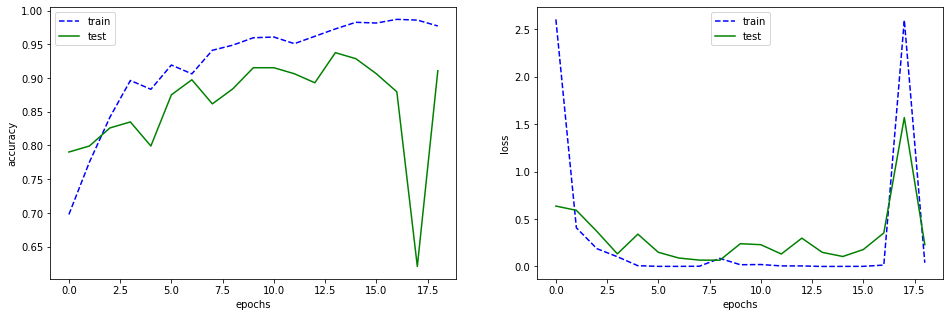

False positive: 719, false negative: 645
Test. false positive: 435, false negative: 177


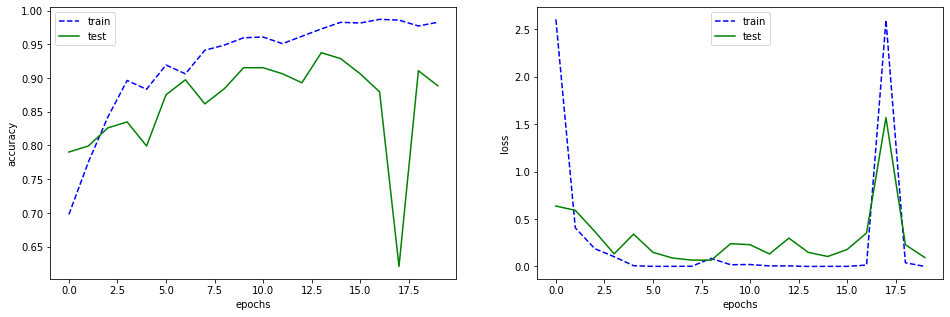

False positive: 724, false negative: 646
Test. false positive: 443, false negative: 183


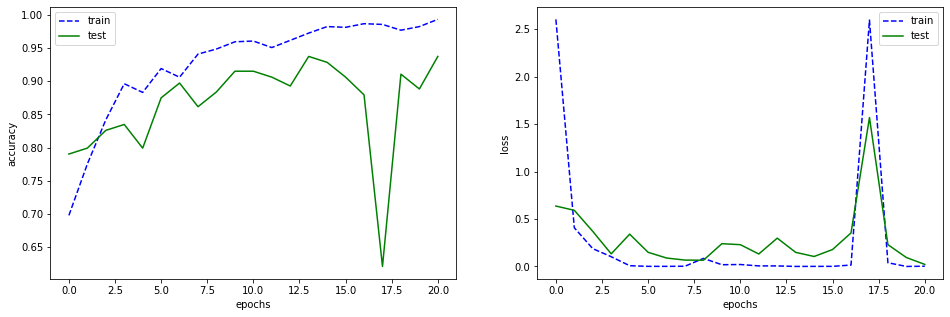

False positive: 727, false negative: 648
Test. false positive: 450, false negative: 197


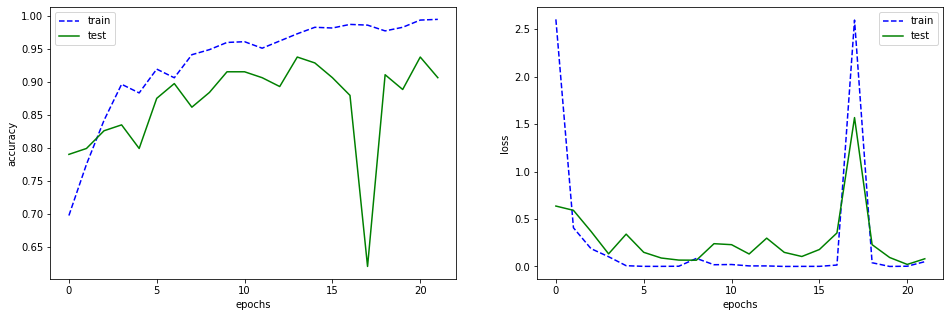

False positive: 732, false negative: 652
Test. false positive: 478, false negative: 199


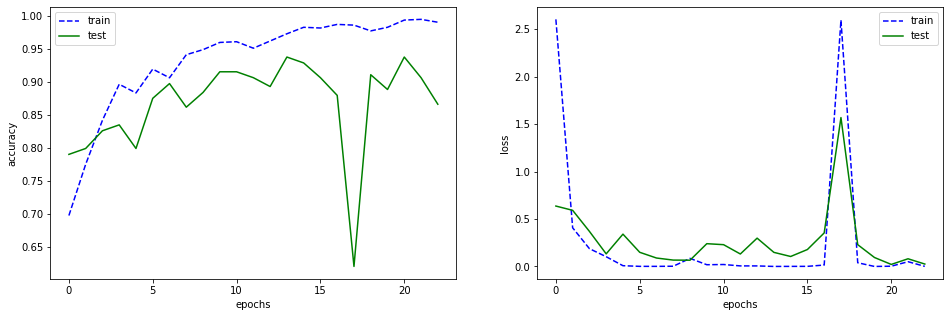

False positive: 737, false negative: 658
Test. false positive: 489, false negative: 205


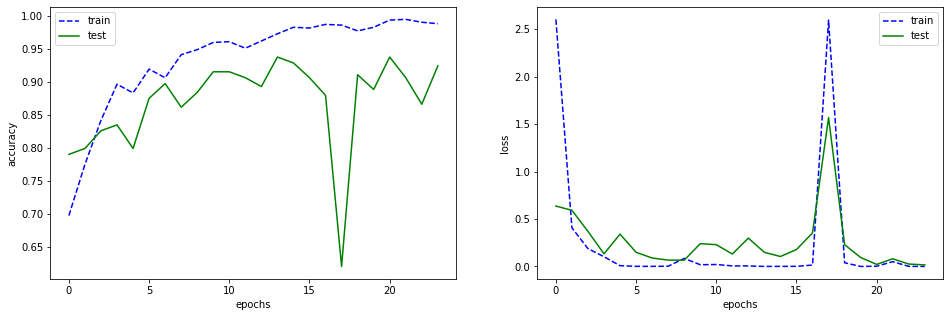

False positive: 738, false negative: 661
Test. false positive: 495, false negative: 219


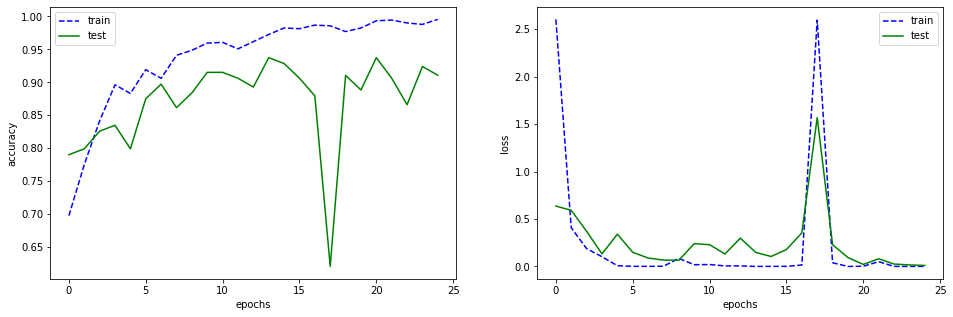

False positive: 738, false negative: 661
Test. false positive: 507, false negative: 223


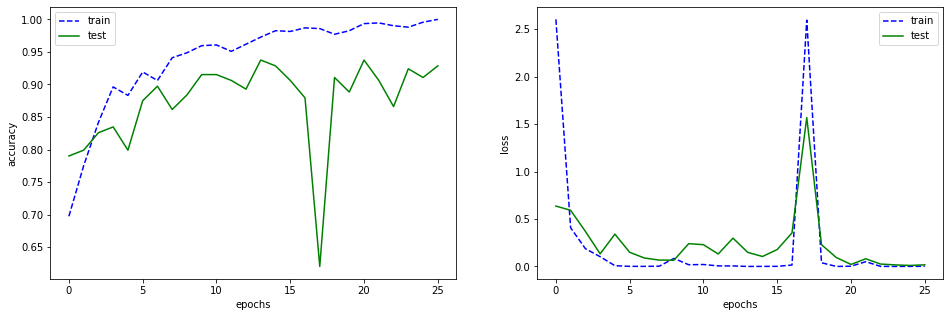

False positive: 740, false negative: 662
Test. false positive: 517, false negative: 229


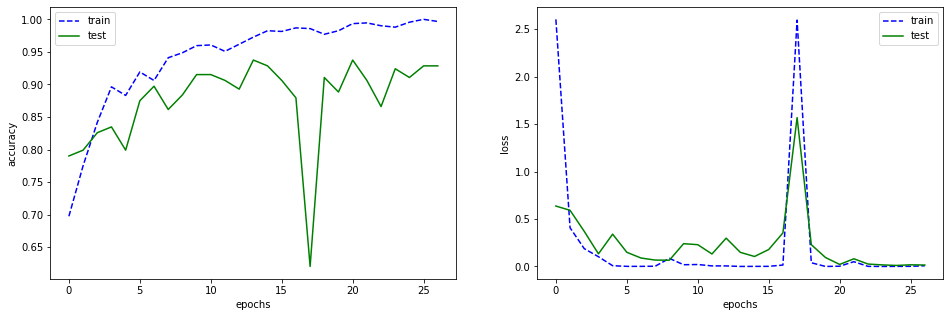

False positive: 743, false negative: 663
Test. false positive: 525, false negative: 238


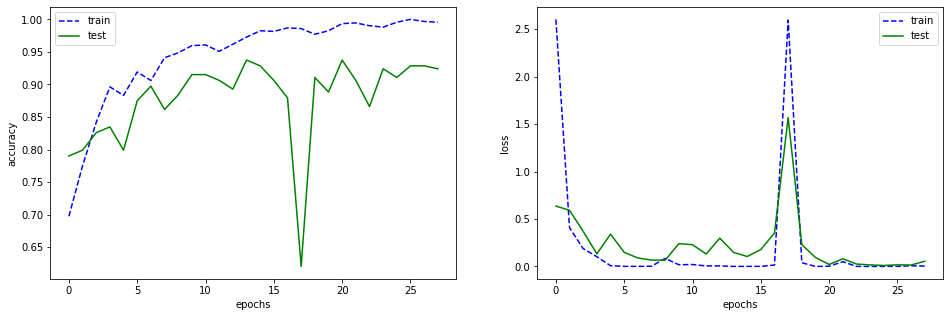

False positive: 746, false negative: 663
Test. false positive: 542, false negative: 241


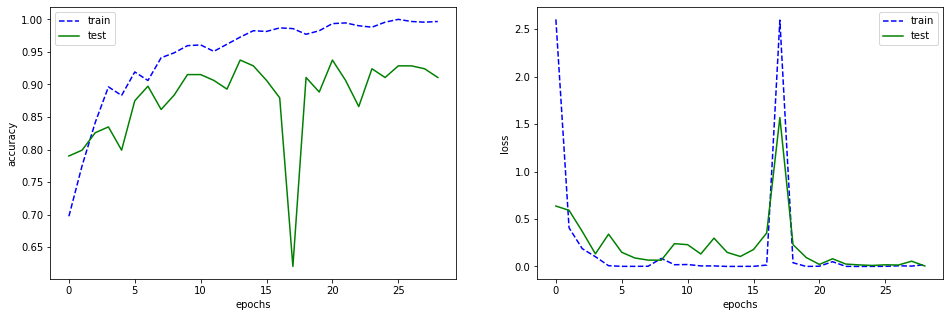

False positive: 747, false negative: 663
Test. false positive: 556, false negative: 246


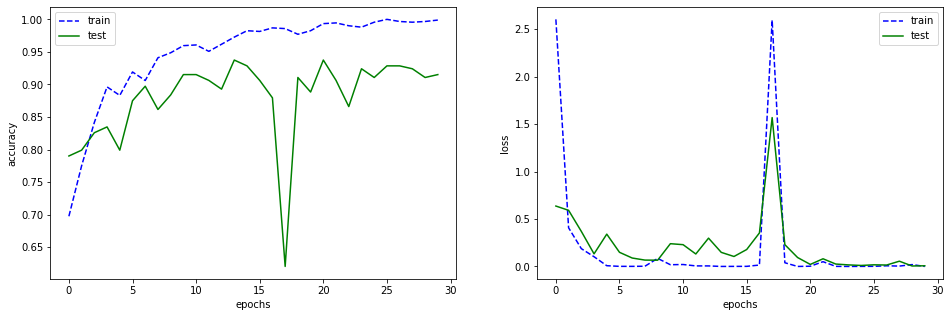

False positive: 750, false negative: 667
Test. false positive: 566, false negative: 252


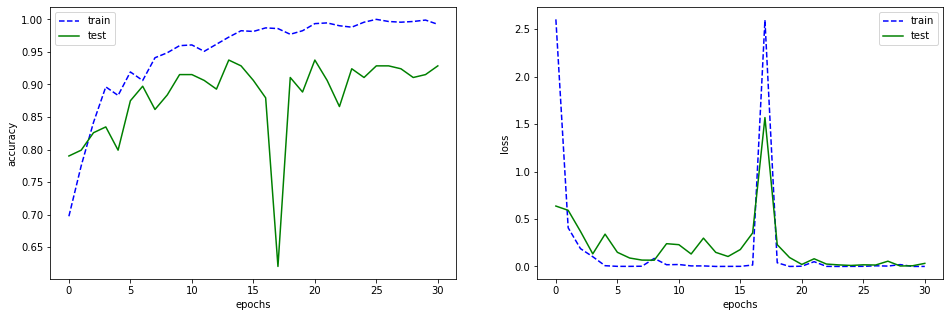

False positive: 754, false negative: 669
Test. false positive: 582, false negative: 254


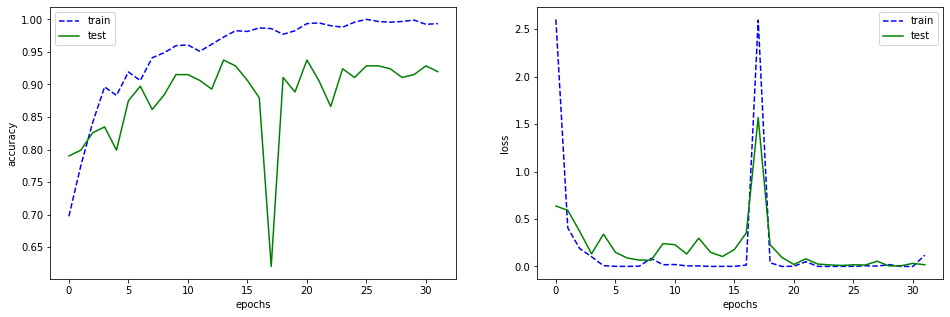

False positive: 755, false negative: 669
Test. false positive: 595, false negative: 259


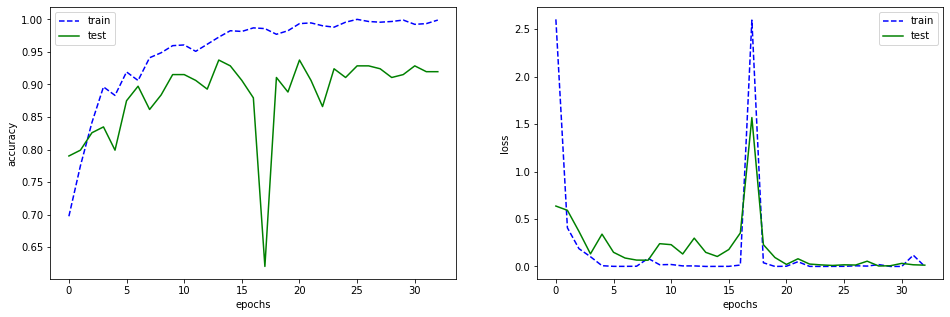

False positive: 762, false negative: 675
Test. false positive: 611, false negative: 260


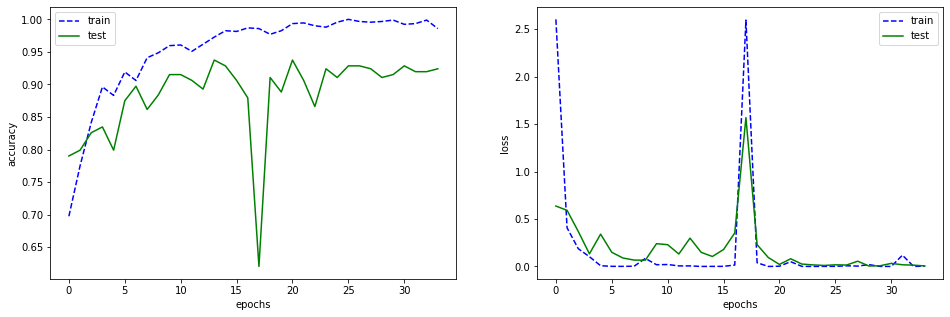

False positive: 765, false negative: 678
Test. false positive: 620, false negative: 267


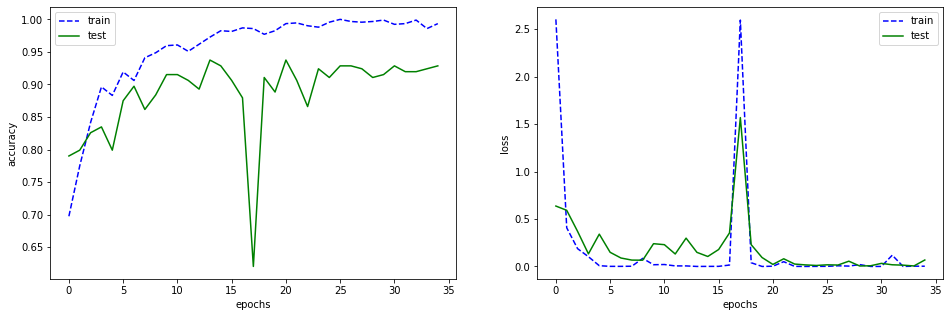

False positive: 767, false negative: 681
Test. false positive: 631, false negative: 277


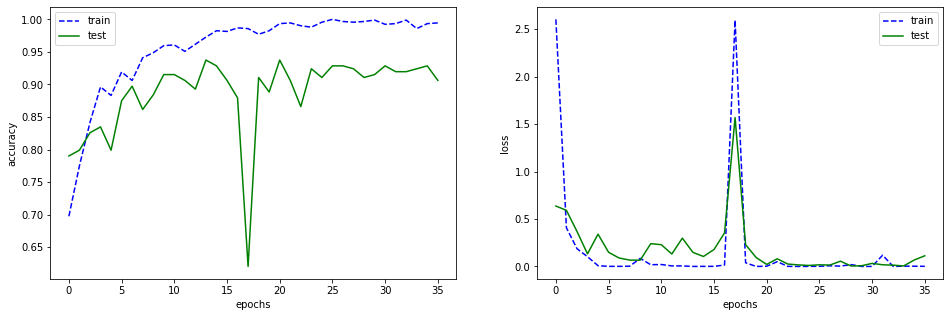

False positive: 770, false negative: 682
Test. false positive: 643, false negative: 285


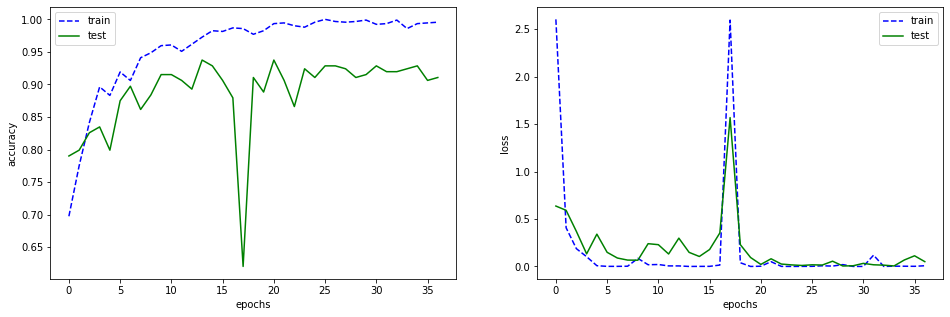

False positive: 772, false negative: 683
Test. false positive: 659, false negative: 288


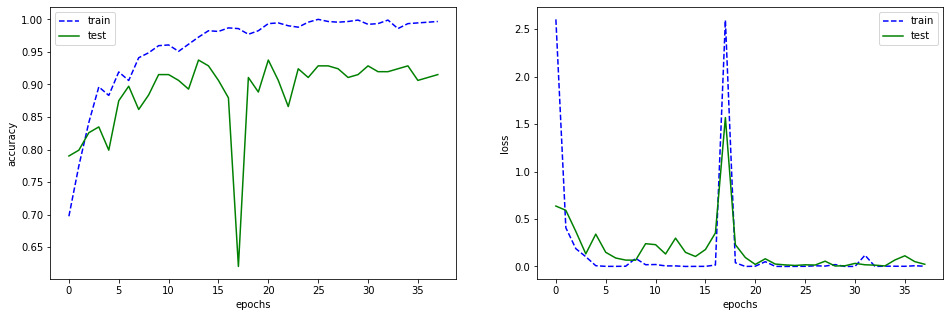

False positive: 775, false negative: 684
Test. false positive: 674, false negative: 294


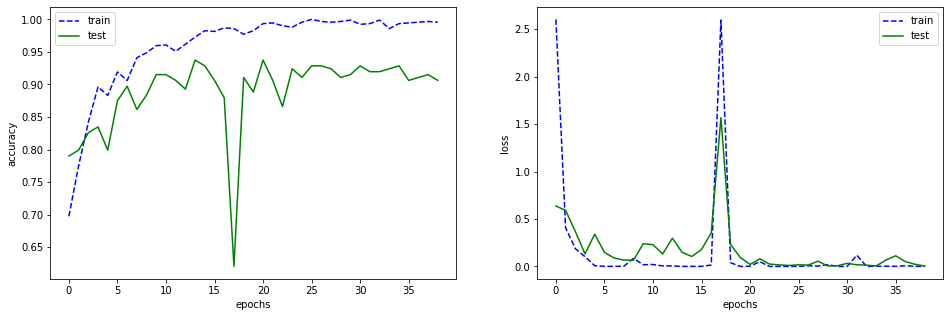

False positive: 778, false negative: 686
Test. false positive: 685, false negative: 305


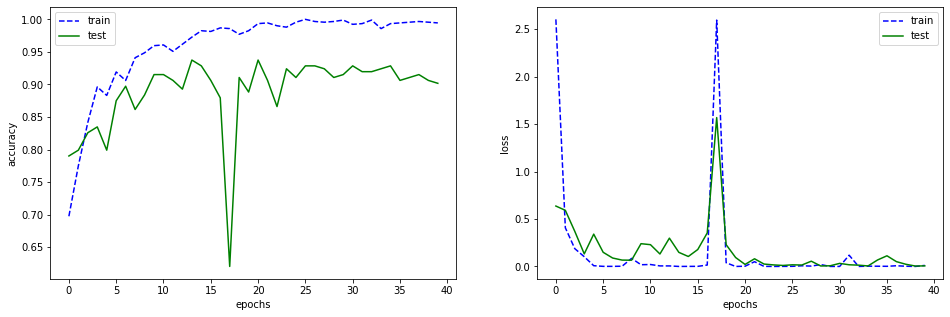

False positive: 778, false negative: 686
Test. false positive: 694, false negative: 312


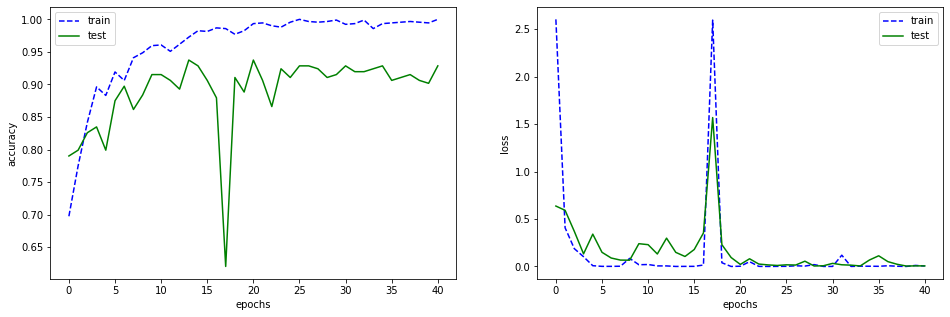

False positive: 778, false negative: 686
Test. false positive: 708, false negative: 315


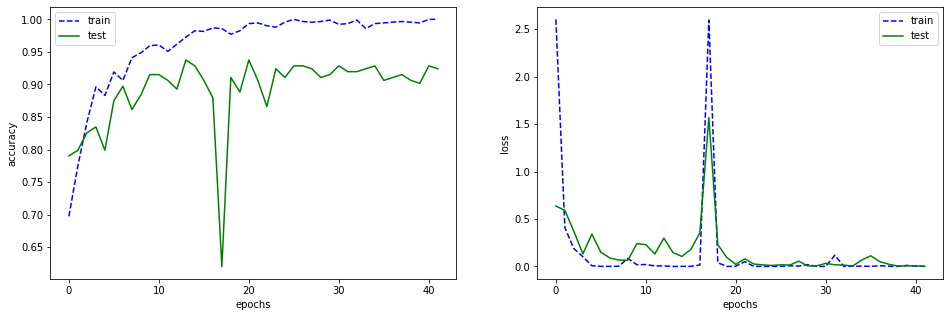

False positive: 778, false negative: 687
Test. false positive: 714, false negative: 325


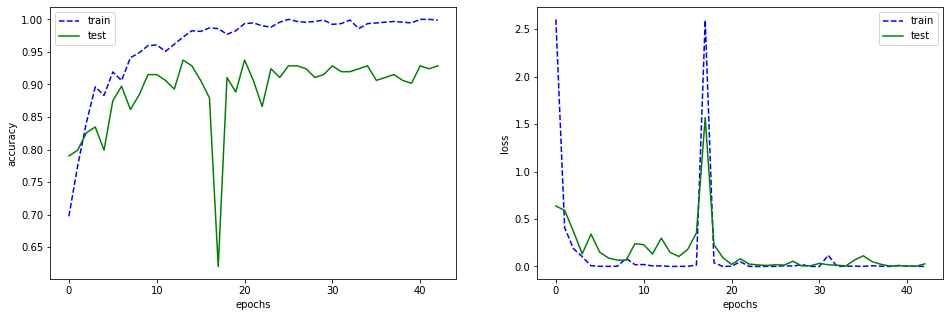

False positive: 779, false negative: 687
Test. false positive: 720, false negative: 336


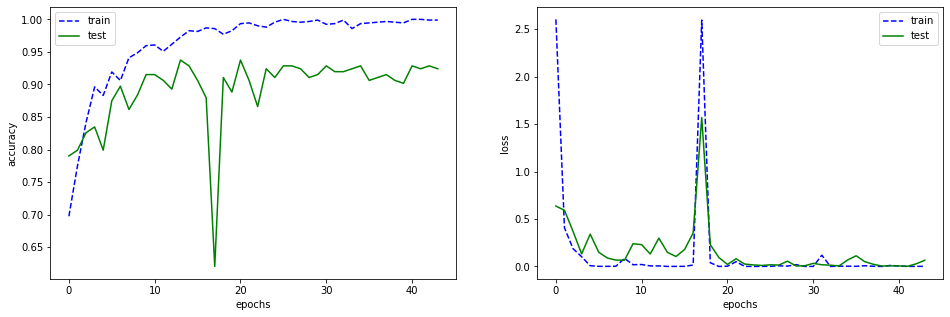

False positive: 779, false negative: 687
Test. false positive: 726, false negative: 347


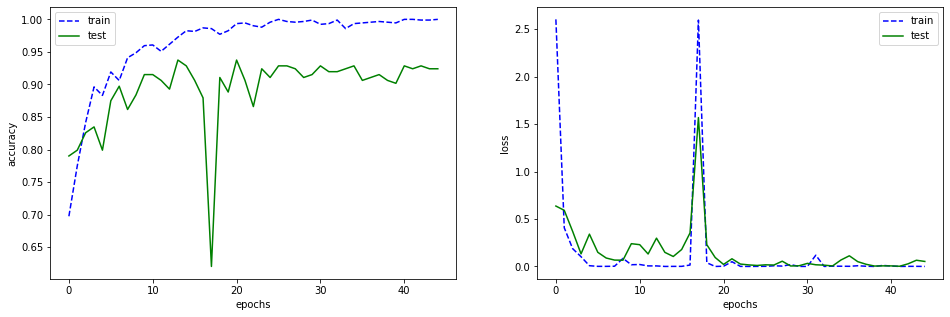

KeyboardInterrupt: ignored

In [29]:
#@title Hyperparameters, training
model = MyModel()
model.double()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
model.to(device)
loss_fn = nn.BCELoss()
LR = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

logs = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}
train(model=model, optimizer=optimizer, loss_fn=loss_fn, learning_rate=LR, n_epochs=200, logs=logs)

In [30]:
#@title save model architecture and performance
from datetime import datetime

timestamp = datetime.now()
test_acc = max(logs['test_accuracy']) * 100
test_loss = min(logs['test_loss'])
train_acc = max(logs['train_accuracy']) * 100
train_loss = min(logs['train_loss'])
!echo "timestamp: $timestamp, test acc: $test_acc, test loss: $test_loss" >> ./performance_history.txt
!echo "train acc: $train_acc, train loss: $train_loss" >> ./performance_history.txt
!echo "$model.__dict__['_modules']" >> ./performance_history.txt
!echo "$optimizer" >> ./performance_history.txt
!echo "train batch: $train_batch_size, test batch: $test_batch_size" >> ./performance_history.txt
!echo "$logs" >> ./performance_history.txt
!echo "Train: fp=$train_fp, fn=$train_fn. Test: fp=$test_fp, fn=$test_fn." >> ./performance_history.txt
!echo "" >> ./performance_history.txt
!echo "" >> ./performance_history.txt

In [40]:
counter = 0
for x, y in train_loader:
  x = x.to(device)
  y = y.to(device)
  optimizer.zero_grad()
  output = model(x)
  output = torch.squeeze(output)
  y_pred = output > 0.5
  for i in range(y.size()[0]):
  #   print(output[i].item(), y[i].item())
  # break
    if y_pred[i] != y[i]:
      print(output[i].item(), y[i].item())
      counter += 1
  if counter == 10: break

0.6934976006583699 0


In [ ]:
#@title GRU_model
class GRU_model(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(GRU_model, self).__init__()
    self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
    self.classifier

  def forward(self, x)